In [1]:
from utils.load import load_dataset, load_summary_files, taxonomy_assignments
from refactor.utils.compute import silhouette_analysis
from timebudget import timebudget

fig_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'
with timebudget('load orig data'):
    O = load_dataset()
    
with timebudget('load folds'):    
    folds_1 = load_summary_files(data_type='NM_cc',lambda_TE=1.0, aug=1, load_gmm=True, fold_list=np.arange(21))
    folds_0 = load_summary_files(data_type='NM_cc',lambda_TE=0.0, aug=0, load_gmm=False)

load orig data took 281.39ms
load folds took 16.123sec


In [2]:
mse_E=[]
mse_T=[]
for i in folds_0.keys():
    test_ind = folds_0[i]['test_ind']
    mse_E.append(np.mean(((O['XE'][test_ind,:]-folds_0[i]['XrE'][test_ind,:])**2)))
    mse_T.append(np.mean(((O['XT'][test_ind,:]-folds_0[i]['XrT'][test_ind,:])**2)))

fold_id = np.array(list(folds_0.keys()))
best_T_model_key = np.argsort(mse_T)
best_T_model_key = fold_id[best_T_model_key]
best_E_model_key = np.argsort(mse_E)
best_E_model_key = fold_id[best_E_model_key]

In [3]:
mse_E=[]
mse_T=[]
for i in folds_0.keys():
    test_ind = folds_1[i]['test_ind']
    mse_E.append(np.mean(((O['XE'][test_ind,:]-folds_1[i]['XrE'][test_ind,:])**2)))
    mse_T.append(np.mean(((O['XT'][test_ind,:]-folds_1[i]['XrT'][test_ind,:])**2)))

fold_id = np.array(list(folds_1.keys()))
best_TE_model_key = np.argsort(np.array(mse_T)+np.array(mse_E))
best_TE_model_key = fold_id[best_TE_model_key]
print(best_TE_model_key[:5])

[17 14  2 15 13]


In [4]:
#Based on 95% test cells (calculated in denovo_clustering notebook):
best_TE_model_key = np.array([11,17,1,14,10])

#### QDA on best uncoupled representations to get 33 taxonomy labels

In [98]:
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from refactor.utils.compute import contingency,contingency_metric

n_best = 5
factor = 1
n_required_classes=33
merged_labels,n_classes = taxonomy_assignments(O['cluster'].copy(),O=O.copy(),n_required_classes=n_required_classes, merge_on='well_sampled')

ami_list_TE = []
ami_list_TE_test = []

ami_list_T_GT = []
ami_list_T_GT_test = []

consistency_TE = []
consistency_TE_test = []


#For transcriptomic representation:
for k in range(n_best):
    all_inds = O['well_sampled_ind'].copy()
    test_inds = folds_0[best_E_model_key[k]]['well_sampled_test_ind'].copy()
    train_inds = folds_0[best_E_model_key[k]]['well_sampled_train_ind'].copy()

    zT = folds_0[best_T_model_key[k]]['zT']
    zE = folds_0[best_E_model_key[k]]['zE']
    
    qda = QDA(reg_param=1e-2,store_covariance=True)

    qda.fit(zE[train_inds,:],merged_labels[train_inds])
    lbl_pred_E = qda.predict(zE)

    qda.fit(zT[train_inds,:],merged_labels[train_inds])
    lbl_pred_T = qda.predict(zT)
    

    ami_list_T_GT.append(AMI(lbl_pred_T[all_inds],merged_labels[all_inds]))
    ami_list_T_GT_test.append(AMI(lbl_pred_T[test_inds],merged_labels[test_inds]))

    ami_list_TE.append(AMI(lbl_pred_E[all_inds],lbl_pred_T[all_inds]))    
    ami_list_TE_test.append(AMI(lbl_pred_E[test_inds],lbl_pred_T[test_inds]))

    C_all = contingency(a=lbl_pred_E[all_inds].copy(), b=lbl_pred_T[all_inds].copy(), 
                    unique_a=np.unique(merged_labels).copy(), 
                    unique_b=np.unique(merged_labels).copy())
    _, _, reliable_diag_frac, _, _, _ = contingency_metric(C_all,verbose=False,factor=factor)
    consistency_TE.append(reliable_diag_frac)
    
    C = contingency(a=lbl_pred_E[test_inds].copy(), b=lbl_pred_T[test_inds].copy(), 
                    unique_a=np.unique(merged_labels).copy(), 
                    unique_b=np.unique(merged_labels).copy())
    _, _, reliable_diag_frac, _, _, _ = contingency_metric(C,verbose=False,factor=factor)
    consistency_TE_test.append(reliable_diag_frac)

In [99]:
#from refactor.utils.plots import matrix_scatterplot
#matrix_scatterplot(C_all,[],[],,scale_factor=2)

In [100]:
#print(f'All T vs GT AMI:  {np.mean(ami_list_T_GT):0.3f} + {np.std(ami_list_T_GT):0.3f}')
#print(f'Test T vs GT AMI: {np.mean(ami_list_T_GT_test):0.3f} + {np.std(ami_list_T_GT_test):0.3f}')

#print(f'All T vs E AMI:   {np.mean(ami_list_TE):0.3f} + {np.std(ami_list_TE):0.3f}')
#print(f'Test T vs E AMI:  {np.mean(ami_list_TE_test):0.3f} + {np.std(ami_list_TE_test):0.3f}')

print(f'All T vs E consistency: {np.mean(consistency_TE):0.3f} + {np.std(consistency_TE):0.3f}')
print(f'Test T vs E consistency: {np.mean(consistency_TE_test):0.3f} + {np.std(consistency_TE_test):0.3f}')

All T vs E consistency: 0.259 + 0.012
Test T vs E consistency: 0.259 + 0.012


#### Do same for coupled autoencoder labels with coupled autoencoder labels

In [101]:
ami_list_TE_coupled = []
consistency_list_TE_coupled = []

ami_list_TE_coupled_test = []
consistency_list_TE_coupled_test = []


for k in range(n_best):
    all_inds = O['well_sampled_ind'].copy()
    test_inds = folds_1[best_TE_model_key[k]]['well_sampled_test_ind'].copy()
    train_inds = folds_0[best_TE_model_key[k]]['well_sampled_train_ind'].copy()

    labels_T = folds_1[best_TE_model_key[k]]['ccT_lbl_matched'][all_inds]
    labels_E = folds_1[best_TE_model_key[k]]['ccE_lbl_matched'][all_inds]
    
    C = contingency(a=labels_T.copy(), b=labels_E.copy(), unique_a=np.arange(33), unique_b=np.arange(33))
    _, _, reliable_diag_frac, _, _, _ = contingency_metric(C,verbose=False,factor=factor)
    ami_list_TE_coupled.append(AMI(labels_T,labels_E))
    consistency_list_TE_coupled.append(reliable_diag_frac)
    
    labels_T = folds_1[best_TE_model_key[k]]['ccT_lbl_matched'][test_inds]
    labels_E = folds_1[best_TE_model_key[k]]['ccE_lbl_matched'][test_inds]
    C = contingency(a=labels_T.copy(), b=labels_E.copy(), unique_a=np.arange(33), unique_b=np.arange(33))
    _, _, reliable_diag_frac, _, _, _ = contingency_metric(C,verbose=False,factor=factor)
    ami_list_TE_coupled_test.append(AMI(labels_T,labels_E))
    consistency_list_TE_coupled_test.append(reliable_diag_frac)    
    
    
#print(f'All T vs E AMI: {np.mean(ami_list_TE_coupled):0.3f} + {np.std(ami_list_TE_coupled):0.3f}')
#print(f'Test T vs E AMI: {np.mean(ami_list_TE_coupled_test):0.3f} + {np.std(ami_list_TE_coupled_test):0.3f}')
print(f'All T vs E consistency: {np.mean(consistency_list_TE_coupled):0.3f} + {np.std(consistency_list_TE_coupled):0.3f}')
print(f'Test T vs E consistency: {np.mean(consistency_list_TE_coupled_test):0.3f} + {np.std(consistency_list_TE_coupled_test):0.3f}')

All T vs E consistency: 0.867 + 0.041
Test T vs E consistency: 0.576 + 0.027


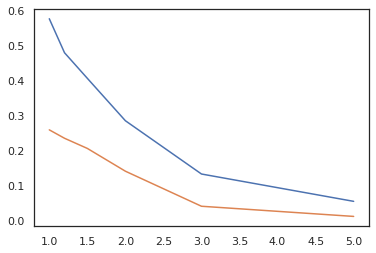

In [104]:
#Mention this in methods - agreement measure is robust to criteria. Below are test sample results.
factors = [1,1.2,1.5,2,3,5]
cplAE = [0.576,0.479,0.406,0.285,0.133,0.055]
unc = [0.259,0.235,0.206,0.141,0.041,0.012]
plt.plot(factors,cplAE)
plt.plot(factors,unc)

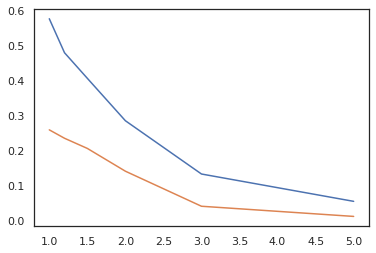